# DSA5105 Individual Project

For this project, I have sought to build some models to **predict the stock prices of S&P500 companies,** as this is also something I will be using in a personal capacity. While their performance has not been much better than random chance, there are many things that can be done to improve the models going forward.

For now, the general approach has been to predict prices by analyzing micro- and macro-economic signals as well as essential technical indicators. There are other data sources that I have prepared as well, which I will incorporate at a later time along with other areas for improvement.

In [67]:
import datetime as dt
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import requests
import json
import glob
import random
import re
from datetime import datetime as dt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, PrecisionRecallDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from scipy.stats import mstats
import keras as ke
import keras.metrics as met
import keras.models as M
import keras.layers as L
from keras.callbacks import EarlyStopping
from keras import optimizers
import keras_tuner as kt
from keras_tuner import HyperModel
from keras_tuner import Tuner
import matplotlib.pyplot as plt
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import yfinance as yf
    from sklearn.cluster import KMeans
path = path = r'C:\YZC\NUS\DSA5105_Principles of Machine Learning\Principles of ML_Project'
os.chdir(path)
print('done')

done


## 1. Data Generation & Processing
This section covers the essential steps taken for data pre-processing and feature generation.

### 1.1 Generate Historical Constituents of S&P500
This dataset was scraped from Wikipedia.

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data = pd.read_html(url)
sp500 = data[0].iloc[:,:7]
sp500.columns = ['ticker','name','sector','sub-industry','headquarters','date','cik']

mask = sp500['date'].str.strip().str.fullmatch('\d{4}-\d{2}-\d{2}')
mask.loc[mask.isnull()] = False
mask = mask == False

current = sp500.copy()
current.loc[mask,'date'] = '1900-01-01'
current.loc[:,'date'] = pd.to_datetime(current['date'])
current.loc[:,'cik'] = current['cik'].apply(str).str.zfill(10)

adjustments = data[1]
columns = ['date','ticker_added','name_added','ticker_removed','name_removed','reason']
adjustments.columns = columns

additions = adjustments[~adjustments['ticker_added'].isnull()][['date','ticker_added','name_added']]
additions.columns = ['date','ticker','name']
additions['action'] = 'added'

removals = adjustments[~adjustments['ticker_removed'].isnull()][['date','ticker_removed','name_removed']]
removals.columns = ['date','ticker','name']
removals['action'] = 'removed'

historical = pd.concat([additions,removals])
missing = current[~current['ticker'].isin(historical['ticker'])].copy()
missing['action'] = 'added'
missing.loc[:,'cik'] = current['cik'].apply(str).str.zfill(10)

sp500_all = pd.concat([historical,missing],join='outer')
sp500_all.loc[:,'date'] = pd.to_datetime(sp500_all['date']).dt.date
sp500_all = sp500_all.sort_values(by=['date','ticker'],ascending=[False,True])
sp500_all = sp500_all.drop_duplicates(subset=['date','ticker'])
sp500_all.to_csv('sp500_constituents.csv',index=False)

In [3]:
sp500 = pd.read_csv('sp500_constituents.csv')
sp500['date'] = pd.to_datetime(sp500['date']).apply(lambda x:x.date())
sp500.head()

,date,ticker,name,action,sector,sub-industry,headquarters,cik
0,2023-10-18,ATVI,Activision Blizzard,removed,NaN,NaN,NaN,NaN
1,2023-10-18,HUBB,Hubbell,added,NaN,NaN,NaN,NaN
2,2023-10-18,LULU,Lululemon Athletica,added,NaN,NaN,NaN,NaN
3,2023-10-18,OGN,Organon & Co.,removed,NaN,NaN,NaN,NaN
4,2023-10-03,DXC,DXC Technology,removed,NaN,NaN,NaN,NaN


In [4]:
# Get the earliest S&P500 involvement date of every stock. For reference during data generation
stocks = sp500['ticker'].unique()
stock_earliest_date = {}
for i in range(len(sp500)):
    stock_earliest_date[sp500.at[i,'ticker']] = sp500.at[i,'date']

### 1.2 Generate Financial Data of S&P500 Stocks
This dataset was obtained from Yahoo via yfinance.

In [ ]:
start = '2000-01-01'
end = '2023-10-31'
start = dt.strptime(start,'%Y-%m-%d').date()
end = dt.strptime(end,'%Y-%m-%d').date()

sp500_fin = pd.DataFrame()
no_data = []
for i in tqdm(stocks):
    s = yf.Ticker(i)
    try: 
        x = s.info['trailingPegRatio']
        if x is None: 
            no_data.append(i)
            continue
    except: 
        no_data.append(i)
        continue
    # tz = s._fetch_ticker_tz(proxy=None,timeout=30)
    if stock_earliest_date[i] < start:
        s_hist = s.history(start=start,end=end,interval='1d')
        if s_hist.empty: 
            no_data.append(i)
            continue
        idx = pd.to_datetime(s_hist.index.values).tz_localize(None)
        s_hist = s_hist.set_index(map(dt.date,idx))
    else: 
        s_hist = s.history(period='max',interval='1d')
        if s_hist.empty: 
            no_data.append(i)
            continue
        idx = pd.to_datetime(s_hist.index.values).tz_localize(None)
        s_hist = s_hist.set_index(map(dt.date,idx))
        earliest_date = pd.to_datetime(s_hist.index.min()).date()
        s_hist = s_hist.loc[max(earliest_date,start):end,:]
    s_hist['stock'] = i
    sp500_fin = pd.concat([sp500_fin,s_hist],join='outer')
    
no_data = pd.DataFrame(no_data,columns=['ticker'])
no_data.to_csv('stocks_no_data.csv',index=False) #398 stocks without data
sp500_fin.to_csv('complete_history.csv')

In [114]:
# Read S&P 500 financial data
sp500 = pd.read_csv('complete_history.csv')
sp500 = sp500.rename({'Unnamed: 0':'Date','stock':'Stock'},axis='columns')
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['Year'] = sp500['Date'].dt.year
sp500.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,Year
0,2000-01-03,1.153400,1.206028,1.023149,1.201642,7226398,0.0,0.0,ATVI,2000
1,2000-01-04,1.175329,1.187609,1.041570,1.165241,4262390,0.0,0.0,ATVI,2000
2,2000-01-05,1.153401,1.196818,1.151208,1.169628,3389998,0.0,0.0,ATVI,2000
3,2000-01-06,1.162173,1.169628,1.137612,1.146823,2429998,0.0,0.0,ATVI,2000
4,2000-01-07,1.162172,1.187609,1.133228,1.178837,15549590,0.0,0.0,ATVI,2000


In [43]:
# Generate IMF indicator list, for reference
x = requests.get('https://www.imf.org/external/datamapper/api/v1/indicators')
indicators = json.loads(x.text)['indicators']
indicators_df = pd.DataFrame([[i,indicators[i]['label'],indicators[i]['description']] for i in indicators],
                             columns=['indicator','label','description'])
indicators_df.to_csv('imf_indicators.csv',index=False)

### 1.3 Generate Macroeconomic Data from IMF
These datasets were obtained from the IMF website. While there were other more granular indicators and data points available, the datasets used here were the only ones covering the desired date range, i.e. 2000-2023.  

In [7]:
# Process IMF indicators
year_range = list(map(str,list(range(2000,2024))))
regions = ['AsiaPacific','MiddleEastCentralAsia','West']
region_stats_yr = pd.DataFrame()
country_region = {}

for f in glob.glob('imf_indicators/*.csv'):
    df = pd.read_csv(f)
    df = pd.melt(df,id_vars=['Country Name','Country Code','Indicator Name','Indicator Code','Attribute'],
            value_vars=year_range,var_name='Year',value_name='Indicator Value')
    m = re.search(r"\\imf_(.*?)\.csv",f)
    region = m.group(1)
    df['Region'] = region
    df = df.sort_values(by=['Country Name','Indicator Name','Year'],ascending=[True,True,True])
    region_stats_yr = pd.concat([region_stats_yr,df])

region_stats_yr.head()       

,Country Name,Country Code,Indicator Name,Indicator Code,Attribute,Year,Indicator Value,Region
127,Australia,193,"Balance of Payments, Current Account, Total, N...",BCA_GDP_BP6,Value,2000,-4.090816,AsiaPacific
368,Australia,193,"Balance of Payments, Current Account, Total, N...",BCA_GDP_BP6,Value,2001,-2.234459,AsiaPacific
609,Australia,193,"Balance of Payments, Current Account, Total, N...",BCA_GDP_BP6,Value,2002,-3.785039,AsiaPacific
850,Australia,193,"Balance of Payments, Current Account, Total, N...",BCA_GDP_BP6,Value,2003,-5.314075,AsiaPacific
1091,Australia,193,"Balance of Payments, Current Account, Total, N...",BCA_GDP_BP6,Value,2004,-6.272747,AsiaPacific


### 1.4 Generate Social Media Data for Apple
This dataset comprises all Reddit comments and posts related to Apple that were created from 2016 to 2021. I've not incorporated this feature into the models yet, but will do so later when I continue working on them for my own use.

In [109]:
df_reddit = pd.DataFrame()
for f in glob.glob('reddit/*.csv'):
    df = pd.read_csv(f)
    df_reddit = pd.concat([df_reddit,df])
df_reddit['created_utc'] = pd.to_datetime(df_reddit['created_utc'],unit='s')
df_reddit = df_reddit.rename({'created_utc':'created_time'},axis='columns')
df_reddit = df_reddit.sort_values(by=['created_time'],ascending=[False])
df_reddit.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_time,permalink,body,sentiment,score,domain,url,selftext,title
0,comment,hitr97r,2qjfk,stocks,False,2021-10-31 23:56:19,https://old.reddit.com/r/stocks/comments/qjvo1...,I own all 3. Don't sell AAPL.,0.0000,1,NaN,NaN,NaN,NaN
1,comment,hitq83x,2qjfk,stocks,False,2021-10-31 23:47:22,https://old.reddit.com/r/stocks/comments/qj07j...,I believe TSLA want to be like AAPL: part hard...,-0.2500,2,NaN,NaN,NaN,NaN
2,comment,hitp3wy,3qd6hq,millennialbets,False,2021-10-31 23:37:43,https://old.reddit.com/r/MillennialBets/commen...,**[Recent News for BABA-](https://www.reddit.c...,0.9422,1,NaN,NaN,NaN,NaN
3,comment,hitnu8x,2qsbv,dividends,False,2021-10-31 23:27:09,https://old.reddit.com/r/dividends/comments/qj...,"O, AAPL, NKE",NaN,1,NaN,NaN,NaN,NaN
4,comment,hitmll9,2qjfk,stocks,False,2021-10-31 23:16:54,https://old.reddit.com/r/stocks/comments/qjvo1...,I have both. CRM has had better revenue and ea...,0.7896,1,NaN,NaN,NaN,NaN


### 1.5 **Feature Generation:** Technical Indicators
These are the main indicators used in mainstream technical analysis.

In [ ]:
unique_stocks = sp500['Stock'].unique()
sp500['Return'] = sp500.groupby('Stock')['Close'].pct_change()

# SMA
sp500['SMA_5'] = sp500.groupby('Stock')['Close'].transform(lambda x: x.rolling(window=5).mean())
sp500['SMA_15'] = sp500.groupby('Stock')['Close'].transform(lambda x: x.rolling(window=15).mean())
sp500['SMA_Ratio'] = sp500['SMA_15']/sp500['SMA_5']

# SMA Volume
sp500['SMA5_Volume'] = sp500.groupby('Stock')['Volume'].transform(lambda x: x.rolling(window=5).mean())
sp500['SMA15_Volume'] = sp500.groupby('Stock')['Volume'].transform(lambda x: x.rolling(window=15).mean())
sp500['SMA_Volume_Ratio'] = sp500['SMA5_Volume']/sp500['SMA15_Volume']

def Wilder(data,periods):
    start = np.where(~np.isnan(data))[0][0]
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean()
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods
    return(Wilder)

# Average True Range
sp500['Prev_Close'] = sp500.groupby('Stock')['Close'].shift(1)
sp500['TR'] = np.maximum((sp500['High'] - sp500['Low']),
                         np.maximum(abs(sp500['High'] - sp500['Prev_Close']),
                                    abs(sp500['Prev_Close'] - sp500['Low'])))
for i in tqdm(unique_stocks):
    TR_data = sp500[sp500.Stock == i].copy().reset_index()
    sp500.loc[sp500.Stock == i,'ATR_5'] = Wilder(TR_data['TR'],5)
    sp500.loc[sp500.Stock == i,'ATR_15'] = Wilder(TR_data['TR'],15)
sp500['ATR_Ratio'] = sp500['ATR_5'] / sp500['ATR_15']

sp500.head()

In [120]:
unique_stocks = sp500['Stock'].unique()

# Stochastic Osclilator
sp500['Lowest_5D'] = sp500.groupby('Stock')['Low'].transform(lambda x: x.rolling(window = 5).min())
sp500['Highest_5D'] = sp500.groupby('Stock')['High'].transform(lambda x: x.rolling(window = 5).max())
sp500['Lowest_15D'] = sp500.groupby('Stock')['Low'].transform(lambda x: x.rolling(window = 15).min())
sp500['Highest_15D'] = sp500.groupby('Stock')['High'].transform(lambda x: x.rolling(window = 15).max())
sp500['Stochastic_5'] = ((sp500['Close'] - sp500['Lowest_5D'])/(sp500['Highest_5D'] - sp500['Lowest_5D']))*100
sp500['Stochastic_15'] = ((sp500['Close'] - sp500['Lowest_15D'])/(sp500['Highest_15D'] - sp500['Lowest_15D']))*100
sp500['Stochastic_%D_5'] = sp500['Stochastic_5'].rolling(window = 5).mean()
sp500['Stochastic_%D_15'] = sp500['Stochastic_5'].rolling(window = 15).mean()
sp500['Stochastic_Ratio'] = sp500['Stochastic_%D_5']/sp500['Stochastic_%D_15']

# Average Directional Index
sp500['prev_high'] = sp500.groupby('Stock')['High'].shift(1)
sp500['prev_low'] = sp500.groupby('Stock')['Low'].shift(1)
sp500['+DM'] = np.where(~np.isnan(sp500.prev_high),
                           np.where((sp500['High'] > sp500['prev_high']) & 
         (((sp500['High'] - sp500['prev_high']) > (sp500['prev_low'] - sp500['Low']))), 
                                                                  sp500['High'] - sp500['prev_high'], 
                                                                  0),np.nan)
sp500['-DM'] = np.where(~np.isnan(sp500.prev_low),
                           np.where((sp500['prev_low'] > sp500['Low']) & 
         (((sp500['prev_low'] - sp500['Low']) > (sp500['High'] - sp500['prev_high']))), 
                                    sp500['prev_low'] - sp500['Low'], 
                                    0),np.nan)

for i in tqdm(unique_stocks):
    ADX_data = sp500[sp500.Stock == i].copy().reset_index()
    sp500.loc[sp500.Stock==i,'+DM_5'] = Wilder(ADX_data['+DM'], 5)
    sp500.loc[sp500.Stock==i,'-DM_5'] = Wilder(ADX_data['-DM'], 5)
    sp500.loc[sp500.Stock==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    sp500.loc[sp500.Stock==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)

sp500['+DI_5'] = (sp500['+DM_5']/sp500['ATR_5'])*100
sp500['-DI_5'] = (sp500['-DM_5']/sp500['ATR_5'])*100
sp500['+DI_15'] = (sp500['+DM_15']/sp500['ATR_15'])*100
sp500['-DI_15'] = (sp500['-DM_15']/sp500['ATR_15'])*100
sp500['DX_5'] = (np.round(abs(sp500['+DI_5'] - sp500['-DI_5'])/(sp500['+DI_5'] + sp500['-DI_5']) * 100))
sp500['DX_15'] = (np.round(abs(sp500['+DI_15'] - sp500['-DI_15'])/(sp500['+DI_15'] + sp500['-DI_15']) * 100))

for i in tqdm(unique_stocks):
    ADX_data = sp500[sp500.Stock == i].copy().reset_index()
    sp500.loc[sp500.Stock==i,'ADX_5'] = Wilder(ADX_data['DX_5'], 5)
    sp500.loc[sp500.Stock==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

# Relative Strength Index
sp500['Diff'] = sp500.groupby('Stock')['Close'].transform(lambda x: x.diff())
sp500['Up'] = sp500['Diff']
sp500.loc[(sp500['Up']<0), 'Up'] = 0

sp500['Down'] = sp500['Diff']
sp500.loc[(sp500['Down']>0), 'Down'] = 0 
sp500['Down'] = abs(sp500['Down'])

sp500['avg_5up'] = sp500.groupby('Stock')['Up'].transform(lambda x: x.rolling(window=5).mean())
sp500['avg_5down'] = sp500.groupby('Stock')['Down'].transform(lambda x: x.rolling(window=5).mean())
sp500['avg_15up'] = sp500.groupby('Stock')['Up'].transform(lambda x: x.rolling(window=15).mean())
sp500['avg_15down'] = sp500.groupby('Stock')['Down'].transform(lambda x: x.rolling(window=15).mean())

sp500['RS_5'] = sp500['avg_5up'] / sp500['avg_5down']
sp500['RS_15'] = sp500['avg_15up'] / sp500['avg_15down']
sp500['RSI_5'] = 100 - (100/(1+sp500['RS_5']))
sp500['RSI_15'] = 100 - (100/(1+sp500['RS_15']))
sp500['RSI_ratio'] = sp500['RSI_5']/sp500['RSI_15']

sp500.head()

100%|████████████████████████████████████████████████████████████████████████████████| 420/420 [03:30<00:00,  1.99it/s]


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,Year,...,Down,avg_5up,avg_5down,avg_15up,avg_15down,RS_5,RS_15,RSI_5,RSI_15,RSI_ratio
0,2000-01-03,1.153400,1.206028,1.023149,1.201642,7226398,0.0,0.0,ATVI,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,1.175329,1.187609,1.041570,1.165241,4262390,0.0,0.0,ATVI,2000,...,0.036401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,1.153401,1.196818,1.151208,1.169628,3389998,0.0,0.0,ATVI,2000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,1.162173,1.169628,1.137612,1.146823,2429998,0.0,0.0,ATVI,2000,...,0.022805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,1.162172,1.187609,1.133228,1.178837,15549590,0.0,0.0,ATVI,2000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# NA Imputation
cols = ['Close','Return','SMA_5','SMA_15','SMA_Ratio','SMA5_Volume','SMA15_Volume','SMA_Volume_Ratio',
       'Prev_Close','TR','ATR_5','ATR_15','ATR_Ratio','Lowest_5D','Highest_5D','Lowest_15D','Highest_15D','Stochastic_5','Stochastic_15',
       'Stochastic_%D_5','Stochastic_%D_15','Stochastic_Ratio','+DI_5','-DI_5','+DI_15','-DI_15',
       'prev_high','prev_low','+DM','-DM','DX_5','DX_15','Diff','Up','Down','ADX_5','ADX_15',
       'avg_5up','avg_5down','avg_15up','avg_15down','RS_5','RS_15','RSI_5','RSI_15','RSI_ratio']
for c in cols:
    sp500[c] = sp500.groupby('Stock')[c].fillna(method = 'bfill')

sp500.head()

### 1.6 **Feature Generation:** Macro-economic Signals
These include key indicators like GDP, Consumer Price Index and Net Government Debt for the major global economies, including Australia, which has been listed as the headquarter country for several S&P500 constituents. I note the following two concerns:
- Comparable data for European economies was not available on the site.
- These indicators are annual numbers that are computed on an end-of-Year or annual-average basis. As such, they technically contain 'future information' from later in the year. However, this is currently the best available dataset for historical macro-economoic information. Finding a better data source, or perhaps suitable proxies of macro-economic climates, is an area of improvement here.

In [122]:
# Merge macro indicators
def process_col(c):
    c = '_'.join(c)
    c = c.replace('Indicator Value_','')
    return c

metrics0 = ['GGXONLB_GDP','GGXWDG_GDP','NGDP_R_PPP_PC_PCH','PPPGDP']
countries = ['United States','China, P.R.: Hong Kong','Australia','Japan','India']
country_stats = region_stats_yr.loc[region_stats_yr['Country Name'].isin(countries)]
country_stats = country_stats.drop(['Indicator Name','Country Code','Attribute','Region'],axis=1).set_index(['Country Name','Indicator Code','Year'])
country_stats = country_stats.drop(metrics0,level=1)
country_stats = country_stats.rename({'China, P.R.: Hong Kong':'China'},level=0)
country_stats = country_stats.unstack(level=[0,1])
rename = {'PCPI_PCH':'CP_avg',
          'PCPIE_PCH':'CP_end',
          'NGDP_RPCH':'GDP',
          'LUR':'UR',
          'BCA_GDP_BP6':'CA',
          'GGXCNL_GDP':'Gov_NetDebt',
}
country_stats = country_stats.rename(rename,axis='columns')
country_stats.columns = country_stats.columns.map(process_col)
country_stats = country_stats.reset_index()
country_stats['Year'] = pd.to_datetime(country_stats['Year'])

#NA Imputation.

cols = [c for c in country_stats.columns if c != 'Year']
for c in cols:
    country_stats[c] = country_stats[c].ffill().bfill()

sp500 = pd.merge(sp500.assign(grouper1=sp500['Date'].dt.to_period('Y')),
                 country_stats.assign(grouper1=country_stats['Year'].dt.to_period('Y')),
                 how='left', on='grouper1')

sp500.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,Year_x,...,Japan_CP_avg,Japan_Gov_NetDebt,Japan_GDP,Japan_UR,United States_CA,United States_CP_end,United States_CP_avg,United States_Gov_NetDebt,United States_GDP,United States_UR
0,2000-01-03,1.153400,1.206028,1.023149,1.201642,7226398,0.0,0.0,ATVI,2000,...,-0.687352,-7.281846,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967
1,2000-01-04,1.175329,1.187609,1.041570,1.165241,4262390,0.0,0.0,ATVI,2000,...,-0.687352,-7.281846,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967
2,2000-01-05,1.153401,1.196818,1.151208,1.169628,3389998,0.0,0.0,ATVI,2000,...,-0.687352,-7.281846,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967
3,2000-01-06,1.162173,1.169628,1.137612,1.146823,2429998,0.0,0.0,ATVI,2000,...,-0.687352,-7.281846,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967
4,2000-01-07,1.162172,1.187609,1.133228,1.178837,15549590,0.0,0.0,ATVI,2000,...,-0.687352,-7.281846,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967


In [ ]:
# Merge fed rates
fed = pd.read_excel('statista_FedRate.xlsx',sheet_name='Data',usecols=[1,2])
fed = fed.drop([0,1,2,3,4]).reset_index(drop=True).rename(columns={'Unnamed: 1':'Month','Unnamed: 2':'Fed_Rate'})
fed['Month'] = pd.to_datetime(fed['Month'],format='%b %Y')
sp500 = pd.merge(sp500.assign(grouper2=sp500['Date'].dt.to_period('M')),
                 fed.assign(grouper2=fed['Month'].dt.to_period('M')),
                 how='left', on='grouper2')

### 1.7 Final Steps in Pre-Processing

In [125]:
# Drop some obviously useless/superfluous columns
columns_drop = ['grouper2','Month']
sp500 = sp500.drop(columns_drop,axis=1)

# Create target variable: positive or negative return
sp500['Target'] = sp500['Return'].apply(lambda x: 1 if x>=0 else 0)
sp500.to_csv('processed_df_v1.csv',index=False)
sp500.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,Year_x,...,Japan_GDP,Japan_UR,United States_CA,United States_CP_end,United States_CP_avg,United States_Gov_NetDebt,United States_GDP,United States_UR,Fed_Rate,Target
0,2000-01-03,1.153400,1.206028,1.023149,1.201642,7226398,0.0,0.0,ATVI,2000,...,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,0
1,2000-01-04,1.175329,1.187609,1.041570,1.165241,4262390,0.0,0.0,ATVI,2000,...,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,0
2,2000-01-05,1.153401,1.196818,1.151208,1.169628,3389998,0.0,0.0,ATVI,2000,...,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,1
3,2000-01-06,1.162173,1.169628,1.137612,1.146823,2429998,0.0,0.0,ATVI,2000,...,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,0
4,2000-01-07,1.162172,1.187609,1.133228,1.178837,15549590,0.0,0.0,ATVI,2000,...,2.764669,4.733333,-3.921,3.427,3.367,-0.537,4.077,3.967,5.45,1


In [2]:
# Back-up & Further House-Cleaning
sp500 = pd.read_csv('processed_df_v1.csv')
sp500 = sp500.drop(['Year_x','Year_y','grouper1'],axis=1)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['Target'] = sp500.groupby('Stock')['Target'].shift(-1)
sp500['Target_Return'] = sp500.groupby('Stock')['Return'].shift(-1)
sp500['Target_Close'] = sp500.groupby('Stock')['Close'].shift(-1)
rand_stocks = random.choices(sp500['Stock'].unique(),k=10) # For stock sampling later

# Create Explanatory Variable DataFrame
sp500_var = sp500.copy() # Overwrite previous variable
sp500_var = sp500_var.drop(['Date','Return','Target','Target_Return','Target_Close'],axis=1)
print('done')

done


In [3]:
# Final Imputation and Troubleshooting for Null & Inf Values
inf_cols = ['Stochastic_5','Stochastic_15','RS_5','RS_15']
for c in inf_cols:
    sp500[c] = sp500[c].replace([np.inf,-np.inf],np.nan)

null_cols = ['SMA_Volume_ratio','Stochastic_5','Stochastic_15','Stochastic_%D_5','Stochastic_%D_15','Stochastic_Ratio',
'+DM_5','-DM_5','+DM_15','-DM_15','RS_5','RS_15','RSI_5','RSI_ratio']
for c in null_cols:
    result = sp500.groupby('Stock')[c].apply(lambda x: x.fillna(x.mean()))
    sp500[c] = result.droplevel(0)

for c in ['Return','Target','Target_Return','Target_Close']:
    sp500[c] = sp500.groupby('Stock')[c].ffill().bfill()
    
num_cols = [c for c in sp500.columns if c not in ['Date','Stock','Year']]
for c in num_cols: 
    if sp500[c].isnull().values.any():
        print('null',c)
    if np.isinf(sp500[c].values).any():
        print('inf',c)
print('done')

done


## 2. Feature Analysis

### 2.1 Correlation Analysis
From the correlations computed below, it appears that there are several clusters of features that are highly correlated with one another. For example, financial indicators correlate strongly with each other, as do macroeconomic indicators within the same country or, in some cases, between two highly connected economies. As such, PCA could be helpful in removing some multicollinearity between features.

In [104]:
# # Correlation Matrix
sp500_var0 = sp500.loc[sp500['Stock'].isin(rand_stocks)]
sp500_var0 = sp500_var0.drop(['Date','Stock'],axis=1)
corr_matrix = sp500_var0.corr()
corr_matrix.to_csv('feature_corr_v1.csv')

# # Quick Analysis
top_corrs = {}
for c in corr_matrix.columns:
    for i in corr_matrix.index:
        val = corr_matrix.at[i,c]
        if abs(val) < 0.99 and abs(val) > 0.3 and (c,i) not in top_corrs.keys():
            top_corrs[(i,c)] = val
top_corrs = pd.Series(top_corrs).sort_values(ascending=False)
top_corrs.to_csv('top_feature_corrs.txt')

In [105]:
corr_matrix = pd.read_csv('feature_corr_v1.csv')
corr_matrix = corr_matrix.rename({'Unnamed: 0':'Feature'},axis='columns')
corr_matrix.head()

,Feature,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,SMA_5,...,United States_CA,United States_CP_end,United States_CP_avg,United States_Gov_NetDebt,United States_GDP,United States_UR,Fed_Rate,Target,Target_Return,Target_Close
0,Open,1.000000,0.999917,0.999911,0.999828,-0.114052,0.055319,0.001769,-0.002630,0.999818,...,0.225133,0.300618,0.276898,-0.200027,0.055946,-0.227337,-0.063828,-0.000399,-0.005883,0.999601
1,High,0.999917,1.000000,0.999878,0.999917,-0.113989,0.055248,0.001769,0.002326,0.999794,...,0.224566,0.300524,0.277035,-0.200676,0.054655,-0.226711,-0.063862,-0.000482,-0.005799,0.999693
2,Low,0.999911,0.999878,1.000000,0.999917,-0.114178,0.055392,0.001587,0.002482,0.999750,...,0.225876,0.300585,0.276433,-0.199570,0.057298,-0.227894,-0.063775,-0.000378,-0.005947,0.999689
3,Close,0.999828,0.999917,0.999917,1.000000,-0.114107,0.055429,0.001558,0.007474,0.999728,...,0.225268,0.300462,0.276626,-0.200149,0.055915,-0.227272,-0.063812,-0.000602,-0.006302,0.999759
4,Volume,-0.114052,-0.113989,-0.114178,-0.114107,1.000000,-0.016140,0.001389,0.014862,-0.114122,...,-0.137701,-0.007056,0.013064,0.016742,-0.003626,0.029267,0.052384,-0.003452,0.012676,-0.114084


### 2.2 Highlighting Significant Attributes
In the following section, I briefly highlight some features that either correlate strongly with prices and/or returns, or have been widely acknowledged to have predictive value.

#### 2.2.1 Simple Moving Averages
These attributes capture autocorrelation in stock prices.

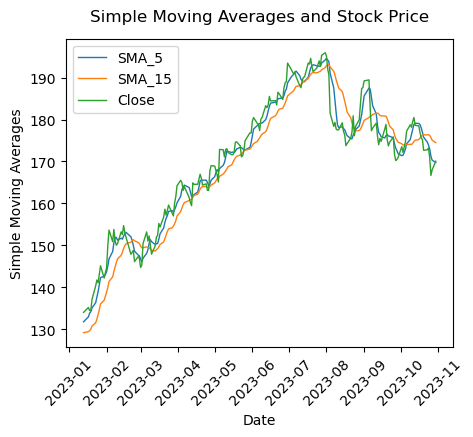

In [86]:
aapl = sp500.loc[sp500['Stock']=='AAPL']
aapl_year_range = aapl['Date'].unique()
aapl = aapl.set_index('Date')
aapl = aapl.loc[aapl_year_range[-200:]]
aapl = aapl.reset_index()

plt.figure(figsize=(5,4))
plt.plot(aapl['Date'],aapl['SMA_5'],linewidth=1,label='SMA_5')
plt.plot(aapl['Date'],aapl['SMA_15'],linewidth=1,label='SMA_15')
plt.plot(aapl['Date'],aapl['Close'],linewidth=1,label='Close')
plt.xlabel('Date')
plt.ylabel('Simple Moving Averages')
plt.title('Simple Moving Averages and Stock Price',y=1.03)
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### 2.2.2 Directional Indices
The DI and DX features capture the strength of price trends.

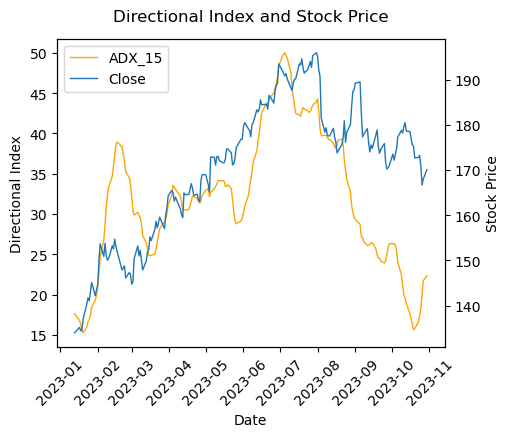

In [89]:
fig,ax1 = plt.subplots(figsize=(5,4))
ax1.set_xlabel('Date')
a, = ax1.plot(aapl['Date'],aapl['ADX_15'],label='ADX_15',color='orange',linewidth=1)
ax1.set_ylabel('Directional Index')
plt.xticks(rotation=45)
ax2 = ax1.twinx()
b, = ax2.plot(aapl['Date'],aapl['Close'],label='Close',linewidth=1)
ax2.set_ylabel('Stock Price')
plt.title('Directional Index and Stock Price',y=1.03)
p = [a,b]
plt.legend(p, [p_.get_label() for p_ in p])
plt.show()

#### 2.2.3 Relative Strength Index
The RSI is a widely used momentum indicator that reflects the speed of price changes.

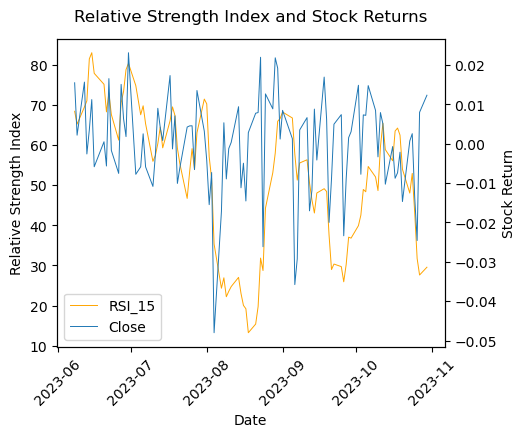

In [91]:
aapl1 = aapl.set_index('Date')
aapl1 = aapl1.loc[aapl_year_range[-100:]]
aapl1 = aapl1.reset_index()
fig,ax1 = plt.subplots(figsize=(5,4))
ax1.set_xlabel('Date')
a, = ax1.plot(aapl1['Date'],aapl1['RSI_15'],label='RSI_15',color='orange',linewidth=0.7)
ax1.set_ylabel('Relative Strength Index')
plt.xticks(rotation=45)
ax2 = ax1.twinx()
b, = ax2.plot(aapl1['Date'],aapl1['Return'],label='Close',linewidth=0.7)
ax2.set_ylabel('Stock Return')
plt.title('Relative Strength Index and Stock Returns',y=1.03)
p = [a,b]
plt.legend(p, [p_.get_label() for p_ in p])
plt.show()

## 3. Model Building
### 3.1 Unsupervised Learning
#### 3.1.1 PCA
As briefly mentioned, it could be valuable to compress the feature array above via PCA, to improve training speeds as well as predictive performance.

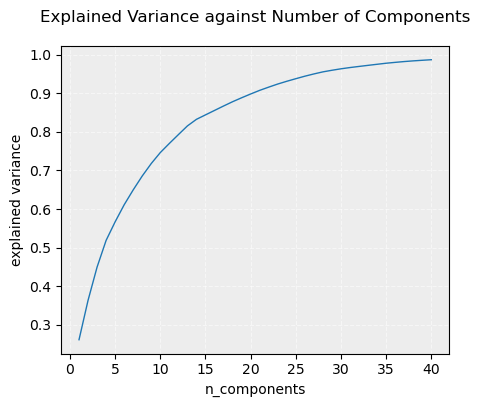

In [37]:
sp500_var1 = sp500_var.drop('Stock',axis=1)
exp_var = pd.DataFrame(columns=['n','var'])
for i in tqdm(range(1,41)):
    pca = PCA(n_components=i)
    pca.fit(sp500_var1)
    exp_var.loc[i-1,'n'] = i
    exp_var.loc[i-1,'var'] = np.sum(list(pca.explained_variance_ratio_))
exp_var.to_csv('pca_explained_variance_v1.csv',index=False)

exp_var = pd.read_csv('pca_explained_variance_v1.csv')
plt.figure(figsize=(5,4))
ax = plt.axes()
ax.set_facecolor('0.93')
plt.grid(color='w',linestyle="--",alpha=0.5,zorder=2)
plt.plot(exp_var['n'],exp_var['var'],linewidth=1)
plt.title('Explained Variance against Number of Components',y=1.05)
plt.xlabel('n_components',y=1.05)
plt.ylabel('explained variance')
plt.show()

From the chart above and the variances computed, I have chosen n_components to be 30 for the rest of this project. While 30 is slightly past the 'elbow', it is also the point beyond which increases in explained variance fall below a certain threshold, based on the individual variances observed (from the exp_var dataframe).

#### 3.1.2 K_Means
It is often useful to try clustering the stocks into organic 'universes', as companies that are similar to each other in certain ways, e.g. adjacent industries, may share certain behaviours or characteristics.

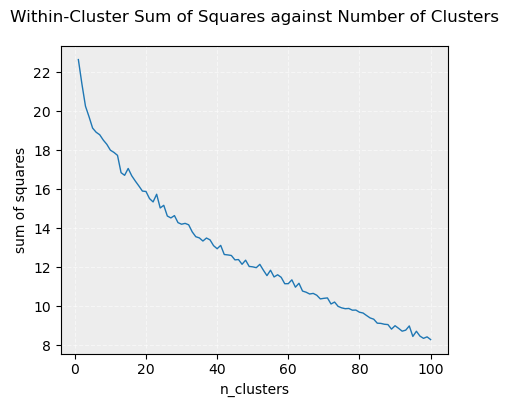

In [39]:
returns = sp500[['Stock','Return','Date']].copy()
returns = returns.pivot(index='Date',columns='Stock',values='Return').dropna().transpose()
kmeans_err = pd.DataFrame(columns=['n','sum_of_sq'])
for n in tqdm(range(1,101)):
    kmeans_err.loc[n-1,'n'] = n
    kmeans_err.loc[n-1,'sum_of_sq'] = KMeans(n_clusters=n,n_init='auto').fit(returns).inertia_
kmeans_err['diff'] = kmeans_err['sum_of_sq'].diff()
kmeans_err.to_csv('kmeans_SumOfSquares.csv',index=False) 

exp_var = pd.read_csv('kmeans_SumOfSquares.csv')
plt.figure(figsize=(5,4))
ax = plt.axes()
ax.set_facecolor('0.93')
plt.grid(color='w',linestyle="--",alpha=0.5,zorder=2)
plt.plot(exp_var['n'],exp_var['sum_of_sq'],linewidth=1)
plt.title('Within-Cluster Sum of Squares against Number of Clusters',y=1.05)
plt.xlabel('n_clusters',y=1.05)
plt.ylabel('sum of squares')
plt.show()

From the findings above, I have chosen n_clusters to be 72, in the same way I have chosen n_components for PCA.

#### 3.1.3 Gaussian Mixture Model and Comparison with KMeans
In this section, I compare the clustering performance of GMM with that of KMeans across different n_cluster/n_component values.

In [58]:
stock_test = random.choices(stock_list,k=150)
stock_train = [s for s in stock_list if s not in stock_test]

returns = sp500[['Stock','Return','Date']].copy()
returns = returns.pivot(index='Date',columns='Stock',values='Return').dropna().transpose()
# returns_train = returns[returns['Stock'].isin(stock_train)]
# returns_test = returns[returns['Stock'].isin(stock_test)]
# returns_train = returns_train.pivot(index='Date',columns='Stock',values='Return').dropna().transpose()
# returns_test = returns_test.pivot(index='Date',columns='Stock',values='Return').dropna().transpose()

scores = pd.DataFrame(columns=['n','GMM','KM','Diff'])
for n in tqdm(range(2,80)):
    GMM = GaussianMixture(n_components=n)
    KM = KMeans(n_clusters=n,n_init='auto')
    GMM.fit(returns)
    KM.fit(returns)
    GMM_pred = GMM.predict(returns)
    KM_pred = KM.predict(returns)
    scores.loc[n-2,'n'] = n
    scores.loc[n-2,'GMM'] = silhouette_score(returns,GMM_pred)
    scores.loc[n-2,'KM'] = silhouette_score(returns,KM_pred)
scores['Diff'] = scores['GMM'] - scores['KM']
scores.to_csv('GMM_KM_comparison.csv',index=False)
scores.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.17it/s]


,n,GMM,KM,Diff
0,2,0.076912,0.062859,0.014054
1,3,0.078535,0.077165,0.00137
2,4,0.021865,0.074712,-0.052847
3,5,0.020388,0.076959,-0.05657
4,6,0.032863,0.047946,-0.015083


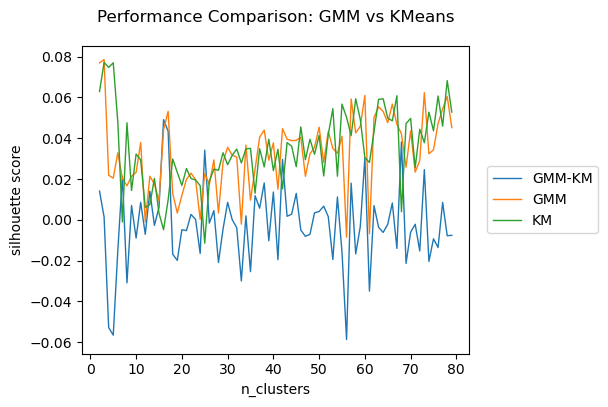

In [63]:
clustering_scores = pd.read_csv('GMM_KM_comparison.csv')
plt.figure(figsize=(5,4))
ax = plt.axes()
plt.plot(clustering_scores['n'],clustering_scores['Diff'],linewidth=1,label='GMM-KM')
plt.plot(clustering_scores['n'],clustering_scores['GMM'],linewidth=1,label='GMM')
plt.plot(clustering_scores['n'],clustering_scores['KM'],linewidth=1,label='KM')
plt.title('Performance Comparison: GMM vs KMeans',y=1.05)
plt.xlabel('n_clusters',y=1.05)
plt.ylabel('silhouette score')
plt.legend(loc='center right',bbox_to_anchor=(1.35,0.5))
plt.show()

The following observations can be made: 
- K-Means seems to frequently outperform Gaussian Mixture for this dataset. 
- Both models score consistently above zero, which suggests some degree of clustering efficacy.

While these clusters can be used as an additional feature or for further analysis, I have left that as a future area of research.

### 3.2 Supervised Learning
#### 3.2.0 **Further Processing**: Creating Time-Series Splits for Cross-Validation
I created my own method for split generation for convenience, as the sklearn functions cannot be used directly for the following reasons:
- Multiple time series (one per stock)
- Each stock has different time periods, due to different listing and de-listing times

That said, I have allowed for a variation of this method that is equivalent to TimeSeriesSplit(), which will be used to create a smaller sample of stocks for faster model training.

In [5]:
stock_list = sp500['Stock'].unique()
date_range = sp500['Date'].unique().to_numpy()

def generate_splits(df,stock_list,date_range,constant_range=False):
    n_splits = 3 # Hard-coded for now
    tot_size = len(date_range)
    each_size = tot_size//5
    train_dates_1 = date_range[:2*each_size]
    idx_splits = {}

    for i in range(n_splits):
        if i == 0:
            train_dates = train_dates_1
            test_dates = date_range[(i+2)*each_size:(i+3)*each_size]
        elif i == n_splits-1:
            train_dates = np.append(train_dates_1,date_range[(i+1)*each_size:(i+2)*each_size])
            test_dates = date_range[(i+2)*each_size:]
        else:
            train_dates = np.append(train_dates_1,date_range[(i+1)*each_size:(i+2)*each_size])
            test_dates = date_range[(i+2)*each_size:(i+3)*each_size]
        idx_splits[i] = [[],[]]
        if constant_range == False:
            for s in tqdm(stock_list):
                temp = df.loc[df['Stock']==s,'Date'].reset_index()
                temp = temp.set_index('Date')
                s_dates = temp.index.values
                s_train_dates = set(train_dates).intersection(set(s_dates))
                s_test_dates = set(test_dates).intersection(set(s_dates))
                if len(s_train_dates) > 0:
                    train_idx = temp.loc[list(s_train_dates),'index'].values
                    idx_splits[i][0].extend(train_idx)
                if len(s_test_dates) > 0:
                    test_idx = temp.loc[list(s_test_dates),'index'].values
                    idx_splits[i][1].extend(test_idx)
        else: # Equivalent to a simple Time Series Split
            for s in tqdm(stock_list): 
                temp = df.loc[df['Stock']==s,'Date'].reset_index()
                temp = temp.set_index('Date')
                train_idx = temp.loc[list(train_dates),'index'].values
                idx_splits[i][0].extend(train_idx)
                test_idx = temp.loc[list(test_dates),'index'].values
                idx_splits[i][1].extend(test_idx)
    return idx_splits

idx_splits = generate_splits(sp500,stock_list,date_range)
idx_splits1 = idx_splits
for a in tqdm(range(len(idx_splits))):
    for b in range(len(idx_splits[a])):
        for c in range(len(idx_splits[a][b])):
            idx_splits1[a][b][c] = str(idx_splits[a][b][c])
with open('idx_splits.json','w') as fp:
    json.dump(idx_splits1,fp)
print('done')

In [ ]:
# Re-load idx_splits: for speed and convenience
with open('idx_splits.json') as json_file:
    idx_splits = json.load(json_file)
for a in tqdm(range(len(idx_splits))):
    for b in range(len(idx_splits[str(a)])):
        for c in range(len(idx_splits[str(a)][b])):
            idx_splits[str(a)][b][c] = int(idx_splits[str(a)][b][c])
idx_splits = {int(k):v for k,v in idx_splits.items()}

#### 3.2.0 **Further Processing**: Data Pipelines
Includes scaling and one-hot encoding. PCA is not included here but will be implemented later for my own comparison.
As this array covers all stocks and features, I will only be using it for simpler linear models like ridge regression.

In [6]:
# Full Dataset
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].to_numpy()

cat_vars = ['Stock']
num_vars = list(set(sp500_var.columns) - set(cat_vars))
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_vars)),
    ('scaler',StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_vars)),
    ('ohe',OneHotEncoder()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])
X_processed = full_pipeline.fit_transform(sp500_var)
print('done')

done


To improve training speeds for more complex models, I have created a feature array covering a smaller sample of stocks. I have also generated a separate, restructured array for LSTM training (stock x year x features).

In [ ]:
possible_stocks = []
aapl_dates = set(sp500.loc[sp500['Stock']=='AAPL','Date'].to_numpy())
for s in tqdm(stock_list):
    if set(sp500.loc[sp500['Stock']==s,'Date'].to_numpy()) == aapl_dates:
        possible_stocks.append(s)
print(possible_stocks)

In [ ]:
possible_stocks = ['AAPL','CCI', 'USB', 'ADI', 'PNW', 'QCOM']
sp500_lstm = sp500.loc[sp500['Stock'].isin(possible_stocks)].reset_index(drop=True)
num_pipeline1 = Pipeline([
    ('selector',DataFrameSelector(num_vars)),
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=30))
])
cat_pipeline1 = Pipeline([
    ('selector',DataFrameSelector(cat_vars)),
    ('ohe',OneHotEncoder()),
])
full_pipeline1 = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline1),
    ('cat_pipeline',cat_pipeline1),
])
X1 = full_pipeline1.fit_transform(sp500_lstm).toarray()

# For NN/LSTM
X1_cols = list(np.arange(30))
X1_cols.extend(cat_pipeline1['ohe'].get_feature_names_out())
X1_df = pd.DataFrame(X1,columns=X1_cols)
X1_nn = []
y_nn = []
for s in tqdm(possible_stocks):
    X1_nn.append(X1_df.loc[X1_df[f'x0_{s}']==1].to_numpy())
    y_nn.append(sp500_lstm.loc[sp500_lstm['Stock']==s,'Target'].to_numpy())
X1_nn = np.asarray(X1_nn) #(6, 5995, 36)
y_nn = np.asarray(y_nn)
print(X1_nn.shape, y_nn.shape)

# Generate new index splits for smaller dataset
aapl_date_range = sp500_lstm['Date'].unique()
idx_splits2 = generate_splits(sp500_lstm,possible_stocks,aapl_date_range,True)

#### 3.2.0 **Further Processing**: Object for Model Training
Includes 3-split cross-validation and a function for plotting confusion matrices.

In [71]:
class Estimator:
    def __init__(self,classifier):
        self.classifier = classifier
    
    def cross_val_scores(self,X,y,idx_splits):
        accuracy = []
        precision = []
        recall = []
        cm = np.zeros((2,2))
        n_splits=len(idx_splits)
        for i in tqdm(range(n_splits)):
            X_train, y_train = X[idx_splits[i][0]],y[idx_splits[i][0]]
            X_test, y_test = X[idx_splits[i][1]],y[idx_splits[i][1]]
            clf = self.classifier.fit(X_train,y_train)
            accuracy.append(clf.score(X_test,y_test))
            y_pred = clf.predict(X_test)
            precision.append(precision_score(y_test,y_pred,average=None))
            recall.append(recall_score(y_test,y_pred,average=None))
            cm += confusion_matrix(y_test,y_pred)
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.cm = cm
        self.clf = clf
            
    def display_scores(self):
        print('Accuracy: ',np.mean(self.accuracy),self.accuracy,
     '\nPrecision: ',np.mean([i[0] for i in self.precision]),list(self.precision),
     '\nRecall: ',np.mean([i[0] for i in self.recall]),list(self.recall))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.cm,display_labels=self.clf.classes_)
        disp.plot()
        plt.show()

#### 3.2.1 Ridge Classifier (All Stocks)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:41<00:00, 133.81s/it]


Accuracy:  0.5203952207588877 [0.5205026119871593, 0.5177152970151009, 0.5229677532744027] 
Precision:  0.48480655654355 [array([0.4836188 , 0.53835038]), array([0.47552959, 0.53568603]), array([0.49527128, 0.52449192])] 
Recall:  0.23145431392861673 [array([0.3363944 , 0.68299259]), array([0.30375738, 0.70568041]), array([0.05421116, 0.94970584])]


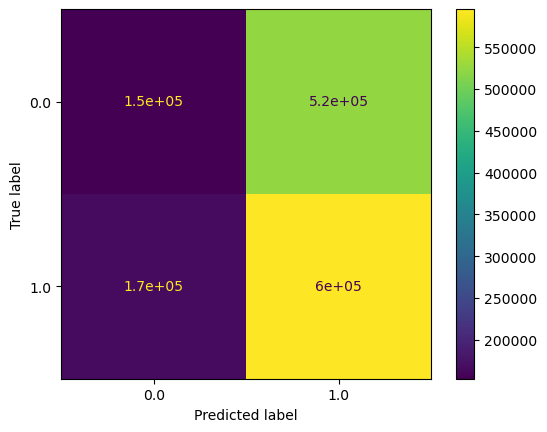

In [57]:
RC = RidgeClassifier()
RC_1 = Estimator(RC)
RC_1.cross_val_scores(X_processed,sp500['Target'],idx_splits)
RC_1.display_scores()

#### 3.2.2 Random Forest Classifier (Sampled Stocks)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.84s/it]

Accuracy:  0.5057455286813085 [0.5045871559633027, 0.5083402835696413, 0.5043091465109814] 
Precision:  0.4800460943388394 [array([0.47907898, 0.53724247]), array([0.47849462, 0.54029937]), array([0.48256468, 0.5255635 ])] 
Recall:  0.5318660761163705 [array([0.56995582, 0.44617004]), array([0.52709505, 0.49174745]), array([0.49854736, 0.50959488])]


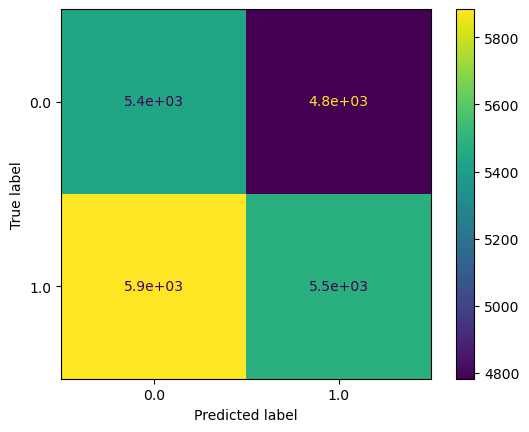

In [96]:
RF = RandomForestClassifier()
RF1 = Estimator(RF)
RF1.cross_val_scores(X1,sp500_lstm['Target'],idx_splits2)
RF1.display_scores()

#### 3.2.3 Support Vector Machine (Sampled Stocks)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:01<00:00, 60.52s/it]

Accuracy:  0.5078769344824391 [0.5061162079510704, 0.4987489574645538, 0.5187656380316931] 
Precision:  0.4805196980967638 [array([0.47996957, 0.53784615]), array([0.46820328, 0.52936265]), array([0.49338624, 0.52551918])] 
Recall:  0.4245262793419533 [array([0.55758468, 0.46012108]), array([0.4992597 , 0.49829709]), array([0.21673446, 0.79584222])]


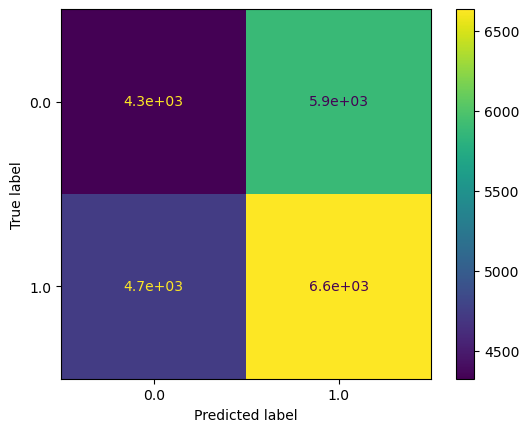

In [90]:
SVM = SVC()
SVM_1 = Estimator(SVM)
SVM_1.cross_val_scores(X1,sp500_lstm['Target'],idx_splits2)
SVM_1.display_scores()

#### 3.2.4 Ridge Classifier (Sampled Stocks)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.89it/s]


Accuracy:  0.4968028912983042 [0.5037531276063386, 0.49263274951348346, 0.49402279677509037] 
Precision:  0.4735914129142162 [array([0.47366837, 0.52957892]), array([0.47112333, 0.53384678]), array([0.47598253, 0.51822917])] 
Recall:  0.5643671556004827 [array([0.46362297, 0.53961569]), array([0.65946106, 0.34503537]), array([0.57001743, 0.42430704])]


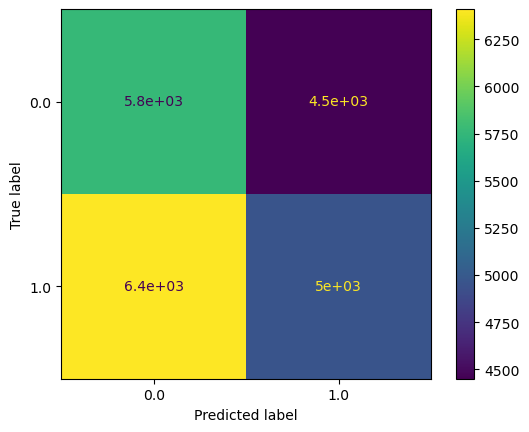

In [98]:
RC = RidgeClassifier()
RC_1 = Estimator(RC)
RC_1.cross_val_scores(X1,sp500_lstm['Target'],idx_splits2)
RC_1.display_scores()

#### 3.2.5 Gradient Boost Classifier (Sampled Stocks)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:31<00:00, 50.57s/it]

Accuracy:  0.507459920303957 [0.5054211843202668, 0.5033361134278566, 0.5136224631637476] 
Precision:  0.4788509213990669 [array([0.4742007 , 0.52986369]), array([0.47127784, 0.53225806]), array([0.49107422, 0.5316171 ])] 
Recall:  0.4576494956569251 [array([0.44123711, 0.56277968]), array([0.47616227, 0.52737752]), array([0.4555491 , 0.56689765])]


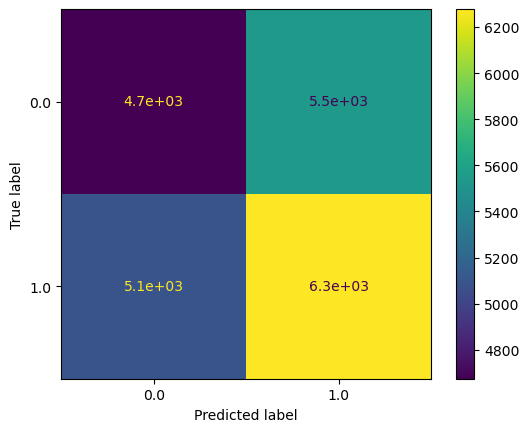

In [72]:
GBC = GradientBoostingClassifier()
GBC_1 = Estimator(GBC)
GBC_1.cross_val_scores(X1,sp500_lstm['Target'],idx_splits2)
GBC_1.display_scores()

#### 3.2.6 Bagging Classifier (Sampled Stocks)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.92s/it]


Accuracy:  0.5077379297562784 [0.5065332221295524, 0.5033361134278566, 0.5133444537114262] 
Precision:  0.4790852362614886 [array([0.4752   , 0.5305972]), array([0.47129467, 0.53227513]), array([0.49076104, 0.53136716])] 
Recall:  0.4563749728318433 [array([0.43740795, 0.56830745]), array([0.4764584 , 0.52711554]), array([0.45525857, 0.56663113])]


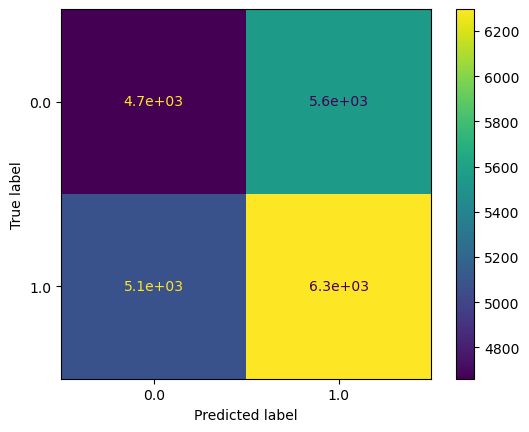

In [73]:
BC = BaggingClassifier()
BC_1 = Estimator(GBC)
BC_1.cross_val_scores(X1,sp500_lstm['Target'],idx_splits2)
BC_1.display_scores()

#### 3.2.7 Performance Comparison (Sampled Stocks)

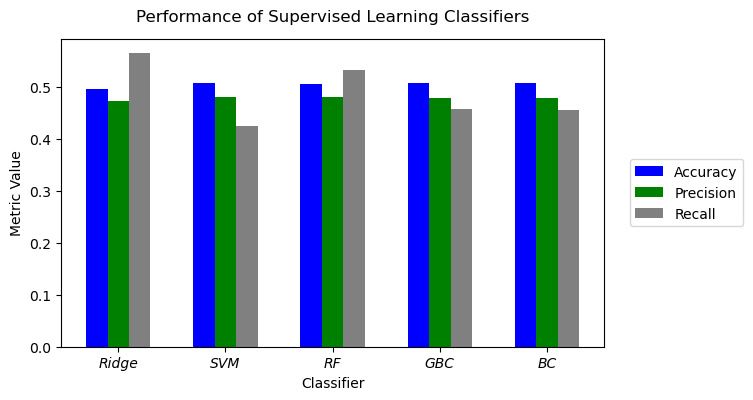

In [77]:
Accuracy = [0.4968028912983042,0.5078769344824391,0.5057455286813085,0.507459920303957,0.5077379297562784]
Precision = [0.4735914129142162,0.4805196980967638,0.4800460943388394,0.4788509213990669, 0.4790852362614886] 
Recall = [0.5643671556004827,0.4245262793419533,0.5318660761163705,0.4576494956569251,0.4563749728318433]

barWidth = 0.2
fig = plt.subplots(figsize=(7,4))
br1 = np.arange(len(Accuracy))
br2 = [x+barWidth for x in br1]
br3 = [x+barWidth for x in br2]

plt.bar(br1,Accuracy,color='b',width=barWidth,label='Accuracy')
plt.bar(br2,Precision,color='g',width=barWidth,label='Precision')
plt.bar(br3,Recall,color='grey',width=barWidth,label='Recall')

plt.xlabel('Classifier')
plt.ylabel('Metric Value')
plt.xticks([r+barWidth for r in range(len(Accuracy))],
           ['Ridge','SVM','RF','GBC','BC'],style='italic')
plt.legend(loc='center right',bbox_to_anchor=(1.27,0.5))
plt.title('Performance of Supervised Learning Classifiers',y=1.03)
plt.show()

For this sample of stocks, it appears that the models do not perform much better, if at all, than random chance. Somewhat surprisingly, Random Forest and Gradient Boosting do not seem to outperform Ridge by any significant margin, and SVM performs best on accuracy and precision among the 5 models.

## Concluding Remarks
I note here that more can be done to truly improve the performance of the models above, which I will look into at my own time (as this is something I will use for my own purposes as a retail investor). These areas include but are not limited to:
- Feature analysis - weeding out noisy and irrelevant features
- Feature generation - analyzing the impact of potentially valuable signals from social media or other contexts, as well as using more suitable macro-economic indicators
- Hyperparameter tuning - there are many parameters that can be experimented with across the models above
- Other models - experimenting with the polynomial kernel, other deep learning models and more